In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Висновки по роботі коду**


# *За осову було взято код з конспекту, а також орієнтовано на код знайдений у Keggle, над яким працювали більш досвідчені розробники.Даний код працює локально у VSCode.Декотрі дані не відобразились, що відобразимо далі.*


Висновок за результатами навчання Seq2Seq

Загальні параметри


1. Корпус: 10 000 train, 2 000 valid, 2 000 test прикладів
2. Словники: EN vocab = 7 024, PL vocab = 12 7833.
3. Архітектура: BiGRU encoder + attention-based GRU decoder
4. Embedding/Hidden dim: 256 / 512
5. Кількість епох: 106.	Dropout: 0.1




Динаміка втрат



1. Епоха 1 4 10
2. Train Loss 6.834 5.156 2.158
3. Valid Loss 6.373 5.787 6.215



* Train Loss стабільно зменшується - модель навчається
* Valid Loss знижується до 4 ї епохи, потім росте - ознаки переобучення
* Test Loss ≈ 5.72, Perplexity ≈ 305 - модель ще не узагальнює добре


Графіки

* Train vs Valid Loss: чітке розходження після 4 ї епохи
* Validation Loss: стабільне зростання - модель втрачає здатність узагальнювати
* Test Loss (бар): підтверджує високу втрату на нових даних
* Attention heatmap: модель частково фокусується на ключових словах, але є шум і невпевненість


Приклади перекладу

* Expected vs Predicted: Часті <unk> - словник не покриває терміни
* Повтори слів («musimy musimy», «europejski europejski») - слабка регуляризація
* Деякі речення мають осмислений початок, але губляться далі
* Attention карта показує часткову відповідність, але не стабільну


Висновки

* Модель навчається, але корпус замалий для складної задачі перекладу
* Valid Loss зростає - потрібна регуляризація або рання зупинка
* Словник має бути розширений або min_freq зменшений
* Переклади частково адекватні, але потребують покращення



Рекомендації

* Збільшити корпус до 50k+ прикладів
* Зменшити min_freq при побудові словника
* Підвищити dropout до 0.3-0.5
* Використати ранню зупинку або зменшити кількість епох
* Спробувати Transformer для кращого узагальненняДодати BLEU/METEOR/ChrF оцінку для об'єктивного порівняння якості



В моєму випадку вдалося получити METEOR.

Висновки:

Що означає METEOR

METEOR (Metric for Evaluation of Translation with Explicit ORdering) 
оцінює переклад за:
* точними збігами слів,
* синонімами,
* стемінгом (коренями слів),
* порядком слів.

Значення метрики лежить у діапазоні 0-1 (де 1 = ідеальний переклад).

Інтерпретація результату
* 0.21 - це низький рівень якості перекладу.

Для порівняння:


* <0.3 - переклад слабкий, багато втрат змісту, <unk>, повторів.
* 0.3–0.5 - середня якість, зрозуміло, але не природно.
* >0.5 - вже прийнятний рівень для практичного використання.




Що можна зробити, щоб підняти METEOR


* Збільшити корпус (зараз 10k прикладів замало).
* Зменшити min_freq - менше <unk>.
* Підвищити dropout - уникнути переобучення.
* Спробувати Transformer - він краще узагальнює для перекладу.
* Додати більше епох + рання зупинка - щоб не втратити узагальнення.



# Висновок по збереженим даним у файлі results.txt який зберігся у кінці роботи коду

Аналіз моделі PL-EN

Динаміка втрат


* Train Loss зменшується - модель навчається
* Valid Loss зростає після 1 ї епохи - чітке переобучення
* Test Loss ≈ 5.72, Perplexity ≈ 305 - модель не узагальнює добре


Графіки

* Train vs Valid Loss (PL-EN) - розходження ще сильніше, ніж у EN-PL
* Validation Loss росте майже лінійно - модель запам’ятовує, але не узагальнює


Якість перекладу

* Багато <unk> - словник не охоплює терміни
* Повтори, спрощення, втрати змісту - attention не стабільний
* Деякі речення мають правильну структуру, але губляться в деталях


Загальний висновок

* Обидві моделі (EN-PL і PL-EN) показують навчання, але не узагальнюють
* Valid Loss росте в обох - потрібні додаткові експерименти з регулюванням даних, більше даних, або інша архітектура
* Test Loss ≈ 5.72, PPL ≈ 305 - переклади слабкі, але є потенціал


Рекомендації


* Збільшити корпус до 50k+
* Зменшити min_freq для словника
* Підвищити dropout
* Додати ранню зупинку
* Спробувати Transformer
* Додати BLEU/METEOR/ChrF для оцінки якості



# Код який відпрацював у VSCode

*зі збереженням результатів у файл та графіки


In [ ]:
# ------------1-----------------
from datasets import DatasetDict
import nltk
import matplotlib
from tqdm import tqdm
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import evaluate
import torch.optim as optim
import torch.nn as nn
import torch
from datasets import load_dataset
import os
import random
from dataclasses import dataclass
from collections import Counter

import pandas as pd
import numpy as np

import spacy

# Завантажуємо моделі для англійської та польської
en_nlp = spacy.load("en_core_web_sm")
pl_nlp = spacy.load("pl_core_news_sm")

warnings.filterwarnings("ignore")

matplotlib.use("Agg")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("punkt")

# ---------2-----------
seed = 42

# Фіксуємо seed для відтворюваності
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Якщо є GPU, можна додати:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ----------3----------------

# Завантажуємо корпус Europarl для англійської та польської
dataset = load_dataset("Helsinki-NLP/europarl", "en-pl")

# Є лише train, тому робимо власний поділ

# Встановимо пропорції: 80% train, 10% valid, 10% test
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
valid_test = split_dataset["test"].train_test_split(test_size=0.5, seed=42)

train_data = split_dataset["train"]
valid_data = valid_test["train"]
test_data = valid_test["test"]

print("Train size:", len(train_data))
print("Valid size:", len(valid_data))
print("Test size:", len(test_data))

# Перевіримо приклад
print(train_data[0]["translation"])


# --------4-----------------

def tokenize_example(example, en_nlp, pl_nlp, max_length, lower, sos_token, eos_token):
    # Беремо англійський та польський текст
    en_text = example["translation"]["en"]
    pl_text = example["translation"]["pl"]

    # Токенізація через spaCy
    en_tokens = [tok.text for tok in en_nlp(en_text)][:max_length]
    pl_tokens = [tok.text for tok in pl_nlp(pl_text)][:max_length]

    # Приведення до нижнього регістру (якщо потрібно)
    if lower:
        en_tokens = [t.lower() for t in en_tokens]
        pl_tokens = [t.lower() for t in pl_tokens]

    # Додаємо спеціальні токени
    en_tokens = [sos_token] + en_tokens + [eos_token]
    pl_tokens = [sos_token] + pl_tokens + [eos_token]

    return {"en_tokens": en_tokens, "pl_tokens": pl_tokens}


# -----------5-----------------
max_length = 100
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "pl_nlp": pl_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

# Беремо лише 10000 прикладів для тренування
small_train = train_data.select(range(10000)).map(
    tokenize_example, fn_kwargs=fn_kwargs)

# Беремо 2000 прикладів для валідації
small_valid = valid_data.select(range(2000)).map(
    tokenize_example, fn_kwargs=fn_kwargs)

# Беремо 2000 прикладів для тесту
small_test = test_data.select(range(2000)).map(
    tokenize_example, fn_kwargs=fn_kwargs)

print("Train size:", len(small_train))
print("Valid size:", len(small_valid))
print("Test size:", len(small_test))


# Перевіримо приклад
print(small_train[0]["translation"])
print("EN tokens:", small_train[0]["en_tokens"])
print("PL tokens:", small_train[0]["pl_tokens"])

# -----------6-----------------
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"
special_tokens = [unk_token, pad_token, sos_token, eos_token]

# Англійський словник
en_counter = Counter(
    token for example in small_train["en_tokens"] for token in example
)
en_vocab_tokens = special_tokens + [
    tok for tok, freq in en_counter.items()
    if freq >= min_freq and tok not in special_tokens
]
en_vocab = {tok: idx for idx, tok in enumerate(en_vocab_tokens)}

# Польський словник
pl_counter = Counter(
    token for example in small_train["pl_tokens"] for token in example
)
pl_vocab_tokens = special_tokens + [
    tok for tok, freq in pl_counter.items()
    if freq >= min_freq and tok not in special_tokens
]
pl_vocab = {tok: idx for idx, tok in enumerate(pl_vocab_tokens)}

# Перевірки: індекси спецтокенів мають збігатися
assert en_vocab[unk_token] == pl_vocab[unk_token]
assert en_vocab[pad_token] == pl_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print("UNK index:", unk_index)
print("PAD index:", pad_index)
print("Index of 'the' in EN vocab:", en_vocab.get("the", unk_index))
print("EN vocab size:", len(en_vocab))
print("PL vocab size:", len(pl_vocab))

# ------------7-----------------


def numericalize_example(example, en_vocab, pl_vocab):
    # Перетворюємо токени у індекси словника
    en_ids = [en_vocab.get(tok, en_vocab["<unk>"])
              for tok in example["en_tokens"]]
    pl_ids = [pl_vocab.get(tok, pl_vocab["<unk>"])
              for tok in example["pl_tokens"]]
    return {"en_ids": en_ids, "pl_ids": pl_ids}


# Використання функції для train/valid/test
fn_kwargs = {"en_vocab": en_vocab, "pl_vocab": pl_vocab}

small_train = small_train.map(numericalize_example, fn_kwargs=fn_kwargs)
small_valid = small_valid.map(numericalize_example, fn_kwargs=fn_kwargs)
small_test = small_test.map(numericalize_example, fn_kwargs=fn_kwargs)

# Перевіримо приклад
print(small_train[0]["translation"])
print("EN tokens:", small_train[0]["en_tokens"])
print("EN ids:", small_train[0]["en_ids"])
print("PL tokens:", small_train[0]["pl_tokens"])
print("PL ids:", small_train[0]["pl_ids"])


# -----------8---------------
# Передаємо словники у функцію numericalize_example
fn_kwargs = {"en_vocab": en_vocab, "pl_vocab": pl_vocab}

# Перетворюємо токени у числові індекси
small_train = small_train.map(numericalize_example, fn_kwargs=fn_kwargs)
small_valid = small_valid.map(numericalize_example, fn_kwargs=fn_kwargs)
small_test = small_test.map(numericalize_example, fn_kwargs=fn_kwargs)

# Перевіримо перший приклад
print("Translation:", small_train[0]["translation"])
print("EN tokens:", small_train[0]["en_tokens"])
print("EN ids:", small_train[0]["en_ids"])
print("PL tokens:", small_train[0]["pl_tokens"])
print("PL ids:", small_train[0]["pl_ids"])

# ------------9--------------------
data_type = "torch"
format_columns = ["en_ids", "pl_ids"]

# Переводимо датасети у torch-формат
small_train = small_train.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)
small_valid = small_valid.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)
small_test = small_test.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

# Перевіримо структуру
print(small_train)
print("Приклад:", small_train[0])
print("EN ids:", small_train[0]["en_ids"])
print("PL ids:", small_train[0]["pl_ids"])

# ------------10-------------------


def get_collate_fn(pad_index):
    def collate_fn(batch):
        # Витягуємо списки індексів для EN та PL
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_pl_ids = [example["pl_ids"] for example in batch]

        # Паддінг послідовностей до однакової довжини
        batch_en_ids = nn.utils.rnn.pad_sequence(
            batch_en_ids, padding_value=pad_index, batch_first=False
        )
        batch_pl_ids = nn.utils.rnn.pad_sequence(
            batch_pl_ids, padding_value=pad_index, batch_first=False
        )

        return {"en_ids": batch_en_ids, "pl_ids": batch_pl_ids}
    return collate_fn

# ---------------11-----------------------


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )


# ---------------12-----------------------------
batch_size = 32

# Створюємо DataLoader-и
train_data_loader = get_data_loader(
    small_train, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(small_valid, batch_size, pad_index)
test_data_loader = get_data_loader(small_test, batch_size, pad_index)

# Перевіримо перший батч
batch = next(iter(train_data_loader))

print("EN ids shape:", batch["en_ids"].shape)  # [src_len, batch_size]
print("PL ids shape:", batch["pl_ids"].shape)  # [trg_len, batch_size]

# Ще один батч для перевірки
batch2 = next(iter(train_data_loader))
print("Другий батч EN ids shape:", batch2["en_ids"].shape)
print("Другий батч PL ids shape:", batch2["pl_ids"].shape)

# ---------------13-------------------------


# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(
            input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim,
                          bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):  # src: [src_len, batch_size]
        # [src_len, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        # outputs: [src_len, batch_size, enc_hidden_dim * 2]
        # hidden:  [2, batch_size, enc_hidden_dim]

        # concat last forward/backward hidden states → project to dec_hidden_dim
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        # hidden: [batch_size, dec_hidden_dim]
        return outputs, hidden


# --- Attention ---
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # repeat hidden across src_len
        # [batch_size, src_len, dec_hidden_dim]
        hidden_rep = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # [batch_size, src_len, enc_hidden_dim*2]
        enc_outs = encoder_outputs.permute(1, 0, 2)

        # [batch_size, src_len, dec_hidden_dim]
        energy = torch.tanh(self.attn_fc(
            torch.cat((hidden_rep, enc_outs), dim=2)))
        # [batch_size, src_len]
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, attention, pad_idx, dropout=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(
            output_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) +
                          embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)                           # [1, batch_size]
        # [1, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(input))

        # [batch_size, src_len]
        a = self.attention(hidden, encoder_outputs)
        # [batch_size, 1, src_len]
        a = a.unsqueeze(1)

        # [batch_size, src_len, enc_hidden_dim*2]
        enc_outs = encoder_outputs.permute(1, 0, 2)
        # [batch_size, 1, enc_hidden_dim*2]
        weighted = torch.bmm(a, enc_outs)
        # [1, batch_size, enc_hidden_dim*2]
        weighted = weighted.permute(1, 0, 2)

        # [1, batch_size, (enc_hidden_dim*2)+emb_dim]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output: [1, batch_size, dec_hidden_dim]
        # hidden: [1, batch_size, dec_hidden_dim]

        # [batch_size, emb_dim]
        embedded = embedded.squeeze(0)
        # [batch_size, dec_hidden_dim]
        output = output.squeeze(0)
        # [batch_size, enc_hidden_dim*2]
        weighted = weighted.squeeze(0)

        # [batch_size, output_dim]
        prediction = self.fc_out(
            torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0), a.squeeze(1)


# --- Seq2Seq ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.8):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size,
                              trg_vocab_size, device=self.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]  # перший токен завжди <sos>

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(dim=1)  # [batch_size]
            input = trg[t] if teacher_force else top1

        return outputs

# ----------------14----------------------


# --- Параметри моделі ---
input_dim = len(en_vocab)   # англійський словник
output_dim = len(pl_vocab)  # польський словник
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './saved_models'
os.makedirs(model_dir, exist_ok=True)

# --- Ініціалізація моделі ---
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    pad_index
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
    pad_index
)

model = Seq2Seq(encoder, decoder, device).to(device)
print(model)

# --- Ініціалізація ваг ---


def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

# --- Оптимізатор та функція втрат ---
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# --- Функція тренування ---


def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        src = batch["en_ids"].to(device)  # англійська
        trg = batch["pl_ids"].to(device)  # польська

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

# --- Функція валідації ---


def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            src = batch["en_ids"].to(device)
            trg = batch["pl_ids"].to(device)

            output = model(src, trg, 0)  # без teacher forcing

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)


# --- Навчання ---
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
best_valid_loss = float("inf")

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs + 1):
    # тренування та валідація
    train_loss = train_fn(
        model, train_data_loader, optimizer,
        criterion, clip, teacher_forcing_ratio, device
    )
    valid_loss = evaluate_fn(model, valid_data_loader, criterion, device)

    # збереження втрат у списки
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # збереження найкращої моделі
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, "en_pl.pt"))

    # логування
    print(f"Epoch {epoch}/{n_epochs}")
    print(f"\tTrain Loss: {train_loss:.3f}")
    print(f"\tValid Loss: {valid_loss:.3f}")
    print(f"\tBest Valid Loss: {best_valid_loss:.3f}")


# ----------------15-----------------------------

# --- Завантаження найкращої моделі ---
model.load_state_dict(torch.load(
    os.path.join(model_dir, "en_pl.pt"),
    map_location=device
))

# --- Оцінка на тестових даних ---
test_loss = evaluate_fn(model, test_data_loader, criterion, device)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")


# ---------------16-------------------------

def translate_sentence(
    sentence,
    model,
    en_nlp,
    pl_nlp,
    en_vocab,
    pl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    # --- Захист від None ---
    if sentence is None or not isinstance(sentence, (str, list)):
        return [sos_token, eos_token], [sos_token, eos_token], torch.zeros(1, 1, 1)

    model.eval()
    with torch.no_grad():
        # --- Токенізація англійського речення ---
        if isinstance(sentence, str):
            en_tokens = [token.text for token in en_nlp(sentence)]
        else:
            en_tokens = [token for token in sentence]

        if lower:
            en_tokens = [token.lower() for token in en_tokens]

        en_tokens = [sos_token] + en_tokens + [eos_token]

        # --- Перетворення токенів у індекси ---
        ids = [en_vocab.get(tok, en_vocab.get("<unk>", 0))
               for tok in en_tokens]
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)  # [src_len, 1]

        # --- Пропуск через енкодер ---
        encoder_outputs, hidden = model.encoder(tensor)

        # --- Початковий вхід у декодер = <sos> ---
        sos_idx = int(pl_vocab.get(sos_token, pl_vocab.get("<unk>", 0)))
        eos_idx = int(pl_vocab.get(eos_token, pl_vocab.get("<unk>", 0)))

        inputs = [sos_idx]
        attentions = torch.zeros(max_output_length, 1, len(ids)).to(device)

        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention

            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)

            if predicted_token == eos_idx:
                break

        # --- Перетворення індексів назад у токени ---
        inv_pl_vocab = {idx: tok for tok, idx in pl_vocab.items()}
        pl_tokens = [inv_pl_vocab.get(idx, "<unk>") for idx in inputs]

        # --- Захист від None / порожнього списку ---
        if not pl_tokens or all(tok is None for tok in pl_tokens):
            pl_tokens = [sos_token, eos_token]

    return pl_tokens, en_tokens, attentions[:len(pl_tokens)-1]


# --------------17------------------------

def plot_attention(sentence_tokens, translation_tokens, attention, max_len=50):
    """
    Візуалізація матриці уваги з обрізанням довжини та виправленням форми.
    """

    # --- Обрізаємо довгі речення ---
    sentence_tokens = sentence_tokens[:max_len]
    translation_tokens = translation_tokens[:max_len]
    attention = attention[:len(translation_tokens), :len(sentence_tokens)]

    # --- Прибираємо зайвий вимір ---
    # shape (target_len, source_len)
    attn_matrix = attention.squeeze(1).cpu().numpy()

    # --- Побудова heatmap ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attn_matrix, cmap="bone")

    ax.set_xticks(range(len(sentence_tokens)))
    ax.set_yticks(range(len(translation_tokens)))
    ax.set_xticklabels(sentence_tokens, rotation=90)
    ax.set_yticklabels(translation_tokens)

    plt.xlabel("Source (EN)")
    plt.ylabel("Target (PL)")
    plt.tight_layout()

    os.makedirs("graphs", exist_ok=True)
    plt.savefig("graphs/attention_example.png")
    plt.close()


# ---------------18------------------------

# Беремо перший приклад із тестових даних
tr = test_data[0].get("translation")

if not tr or not isinstance(tr, dict):
    print("Bad sample at index 0")
else:
    sentence = tr.get("en", "")
    expected_translation = tr.get("pl", "")

    print("English:", sentence)
    print("Expected Polish:", expected_translation)

    # Проганяємо через модель
    translation, sentence_tokens, attention = translate_sentence(
        sentence,
        model,
        en_nlp,
        pl_nlp,
        en_vocab,
        pl_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )

    print("Predicted translation:", " ".join(translation))
    print("Source tokens:", sentence_tokens)

    # Візуалізація уваги
    plot_attention(sentence_tokens, translation, attention)


# -----------19-----------------

# Перекладемо перші 10 прикладів із тестового набору
for i in range(10):
    tr = test_data[i].get("translation")

    # Перевірка, чи є поле translation і чи воно словник
    if not tr or not isinstance(tr, dict):
        print(f"Bad sample at index {i}: translation missing or invalid")
        continue

    sentence = tr.get("en")
    expected_translation = tr.get("pl")

    # Перевірка, чи en/pl є рядками
    if not isinstance(sentence, str) or not isinstance(expected_translation, str):
        print(f"Bad sample at index {i}: en/pl not strings")
        continue

    translation, sentence_tokens, attention = translate_sentence(
        sentence,
        model,
        en_nlp,
        pl_nlp,
        en_vocab,
        pl_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )

    print(f"Example {i+1}")
    print(f"English: {sentence}")
    print(f"Expected Polish: {expected_translation}")
    print(f"Predicted Polish: {' '.join(translation)}")
    print("-" * 60)

    # Візуалізація уваги для кожного прикладу
    if attention is not None and attention.numel() > 0:
        plot_attention(sentence_tokens, translation, attention)
    else:
        print(f"Attention is None/empty for example {i+1}, skipping plot.")


# ----------------------------20----------------------------

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = train_fn(model, train_data_loader, optimizer,
                          criterion, clip, teacher_forcing_ratio, device)
    valid_loss = evaluate_fn(model, valid_data_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

# --- Побудова графіка втрат ---
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Зміна функції втрат (EN→PL)")
plt.legend()
# plt.tight_layout()
# plt.pause(1.0)  # збільшена пауза
# plt.close()

# --- Перекладемо кілька прикладів ---
for i in range(len(test_data)):
    tr = test_data[i].get("translation")

    if not tr or not isinstance(tr, dict):
        print(f"Bad sample at index {i}: translation missing or invalid")
        continue

    sentence = tr.get("en")
    expected_translation = tr.get("pl")

    if not isinstance(sentence, str) or not isinstance(expected_translation, str):
        print(f"Bad sample at index {i}: en/pl not strings")
        continue

    translation, sentence_tokens, attention = translate_sentence(
        sentence,
        model,
        en_nlp,
        pl_nlp,
        en_vocab,
        pl_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )

    print(f"Example {i+1}")
    print(f"English: {sentence}")
    print(f"Expected Polish: {expected_translation}")
    print(f"Predicted Polish: {' '.join(translation)}")

    if attention is not None and attention.numel() > 0:
        plot_attention(sentence_tokens, translation, attention)
    else:
        print(f"Attention is None/empty for example {i+1}, skipping plot.")

# --- METEOR + ChrF оцінка ---
meteor = evaluate.load("meteor")
chrf = evaluate.load("chrf")

preds, refs = [], []
bad_indices = []
limit = len(test_data)  # можна обмежити 500 для швидкої перевірки

for i in range(limit):
    tr = test_data[i].get("translation")

    if not tr or not isinstance(tr, dict):
        bad_indices.append(("no_translation", i, test_data[i]))
        continue

    src = tr.get("en")
    ref_pl = tr.get("pl")

    if not isinstance(src, str) or not isinstance(ref_pl, str):
        bad_indices.append(("bad_types", i, type(src), type(ref_pl)))
        continue

    pred_tokens, _, _ = translate_sentence(
        src, model, en_nlp, pl_nlp, en_vocab, pl_vocab, lower, sos_token, eos_token, device
    )

    if pred_tokens is None or not isinstance(pred_tokens, list):
        bad_indices.append(("pred_none", i, pred_tokens))
        pred_tokens = [sos_token, eos_token]

    pred_tokens = [t for t in pred_tokens if isinstance(t, str)]
    pred_tokens = [t for t in pred_tokens if t not in {
        sos_token, eos_token, "<pad>"}]

    pred_text = " ".join(pred_tokens) if pred_tokens else ""

    if not isinstance(ref_pl, str) or len(ref_pl.strip()) == 0:
        bad_indices.append(("ref_empty", i, ref_pl))
        continue

    # if not isinstance(pred_text, str) or len(pred_text.strip()) == 0:
    #     bad_indices.append(("pred_empty", i, pred_text))
    #     continue

    preds.append(pred_text)
    refs.append([ref_pl])

if bad_indices:
    print("Diagnostics (first 5):", bad_indices[:5])

if len(preds) == 0 or len(refs) == 0:
    print("METEOR/ChrF cannot be computed: empty preds/refs.")
else:
    meteor_score = meteor.compute(predictions=preds, references=refs)
    chrf_score = chrf.compute(predictions=preds, references=refs)

    if meteor_score and "meteor" in meteor_score:
        print(f"METEOR: {meteor_score['meteor']:.4f}")

    else:
        print("METEOR could not be computed")

        if chrf_score and "score" in chrf_score:
            print(f"ChrF: {chrf_score['score']:.4f}")

        else:
            print("ChrF could not be computed")

    # print(f"METEOR: {meteor_score['meteor']:.4f}")
    # print(f"ChrF: {chrf_score['score']:.4f}")

print("preds_len:", len(preds), "refs_len:", len(refs))
print("preds_sample:", preds[:3])
print("refs_sample:", refs[:3])

# --- Статистика ---
print("preds_len:", len(preds), "refs_len:", len(refs))
print("preds_sample:", preds[:3])
print("refs_sample:", refs[:3])


# ----------------------------21----------------------------
os.makedirs("graphs", exist_ok=True)

# --- Train vs Valid Loss ---
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Valid Loss (EN→PL)")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/train_valid_loss.png")
plt.close()

# --- Train Loss ---
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/train_loss.png")
plt.close()

# --- Valid Loss ---
plt.figure(figsize=(8, 6))
plt.plot(valid_losses, label="Valid Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/valid_loss.png")
plt.close()

# --- Test Loss (баром) ---
plt.figure(figsize=(8, 6))
plt.bar(["Test"], [test_loss], color="green")
plt.ylabel("Loss")
plt.title("Test Loss")
plt.tight_layout()
plt.savefig("graphs/test_loss.png")
plt.close()

# --- Збереження результатів у файл TXT ---
with open("results.txt", "w", encoding="utf-8") as f:
    f.write("=== Результати навчання Seq2Seq (PL→EN) ===\n\n")

    # поепохові втрати
    for i, (tr, vl) in enumerate(zip(train_losses, valid_losses), start=1):
        f.write(f"Epoch {i}/{n_epochs}\n")
        f.write(f"\tTrain Loss: {tr:.3f}\n")
        f.write(f"\tValid Loss: {vl:.3f}\n")
        f.write(f"\tBest Valid Loss (so far): {min(valid_losses[:i]):.3f}\n\n")

    # узагальнена статистика
    f.write("Train Losses:\n")
    f.write(", ".join([f"{loss:.4f}" for loss in train_losses]) + "\n\n")
    f.write("Valid Losses:\n")
    f.write(", ".join([f"{loss:.4f}" for loss in valid_losses]) + "\n\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Perplexity: {np.exp(test_loss):.4f}\n\n")
    f.write("Графіки збережені у папку 'graphs/'\n")

print("Done. Результати збережені у results.txt")


# Графіки які були отримані

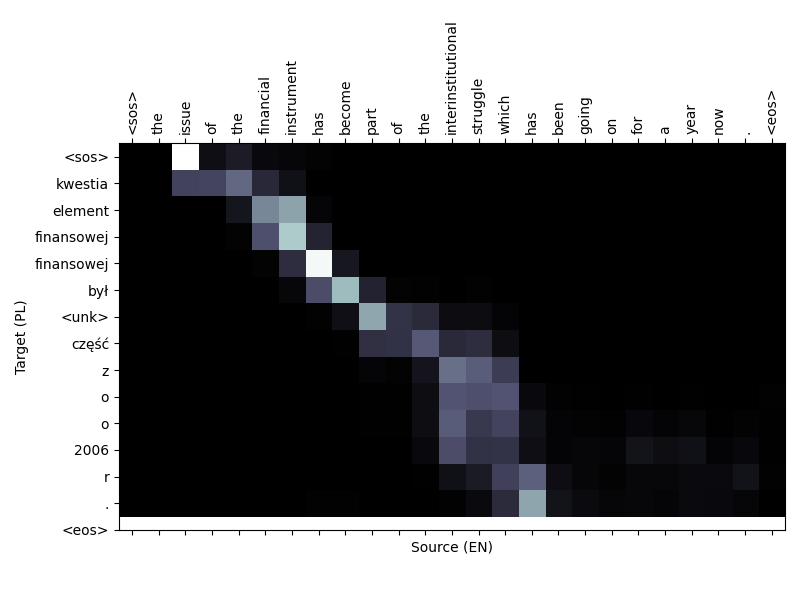
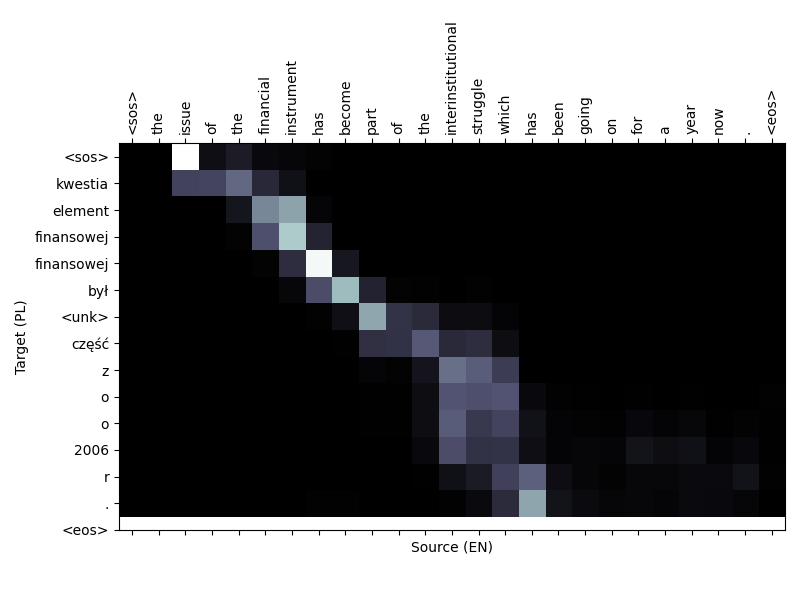

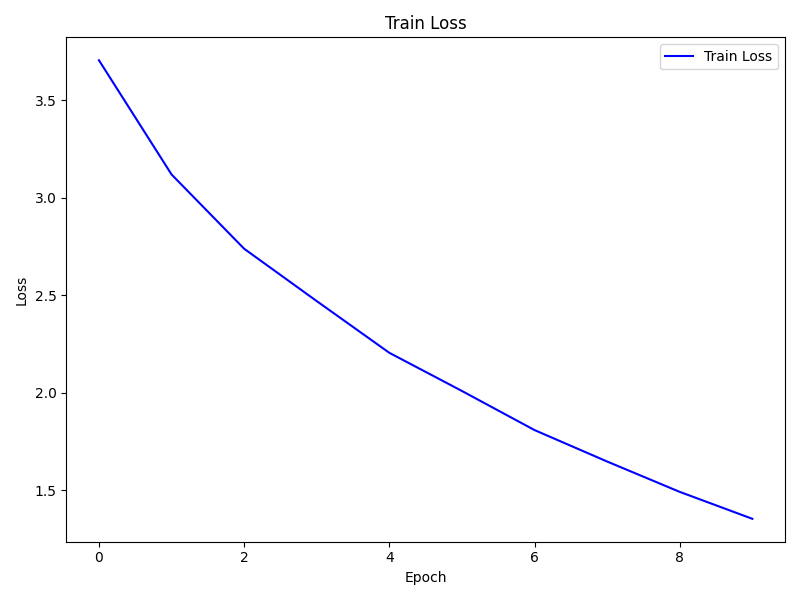

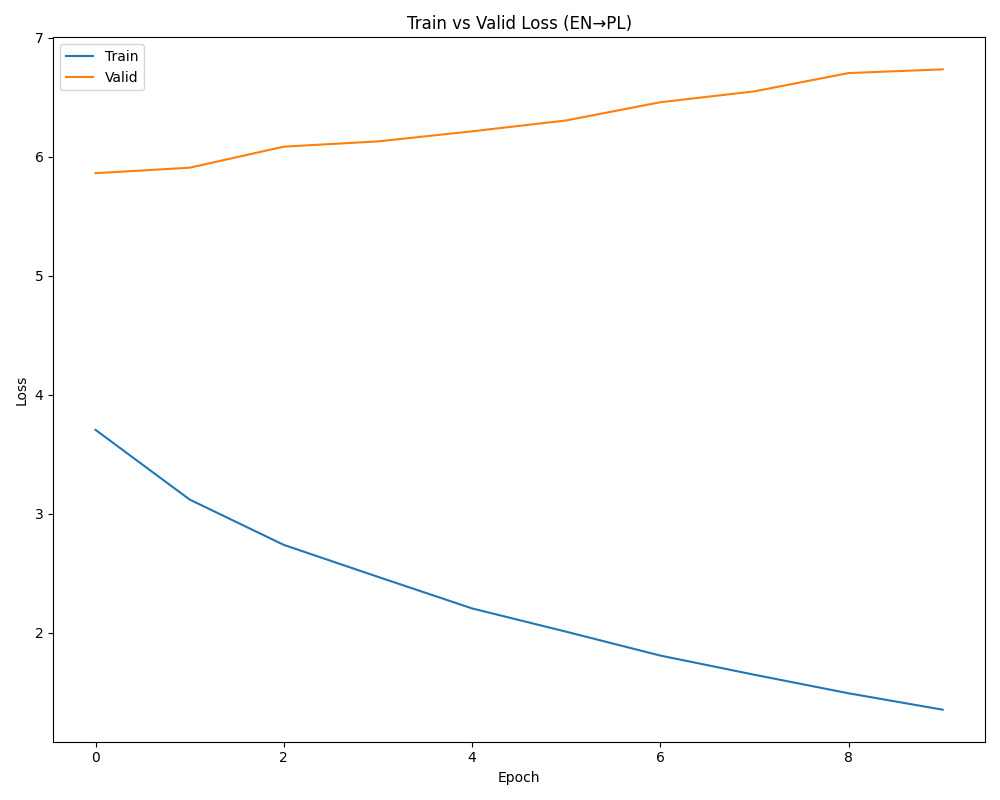

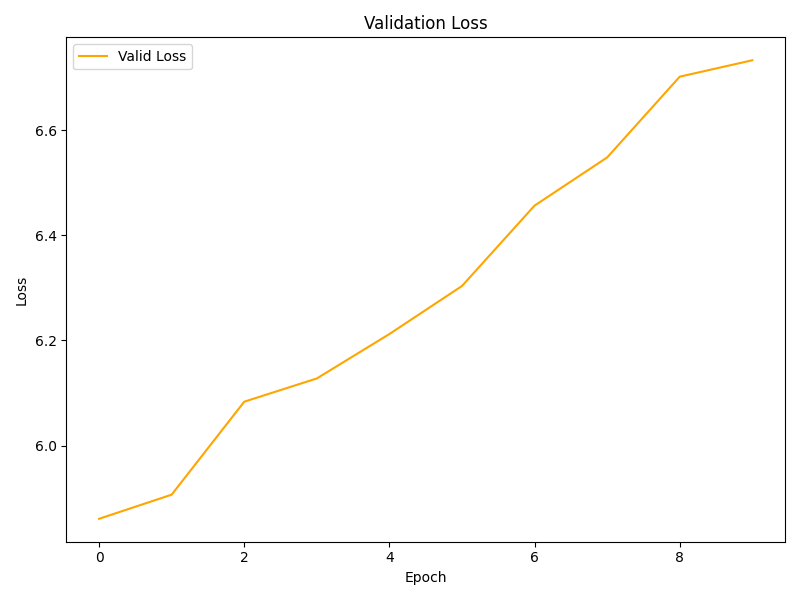

# *Але нажаль не було получено результату нрафіка нижче, над чим зараз і продовжую працювати*

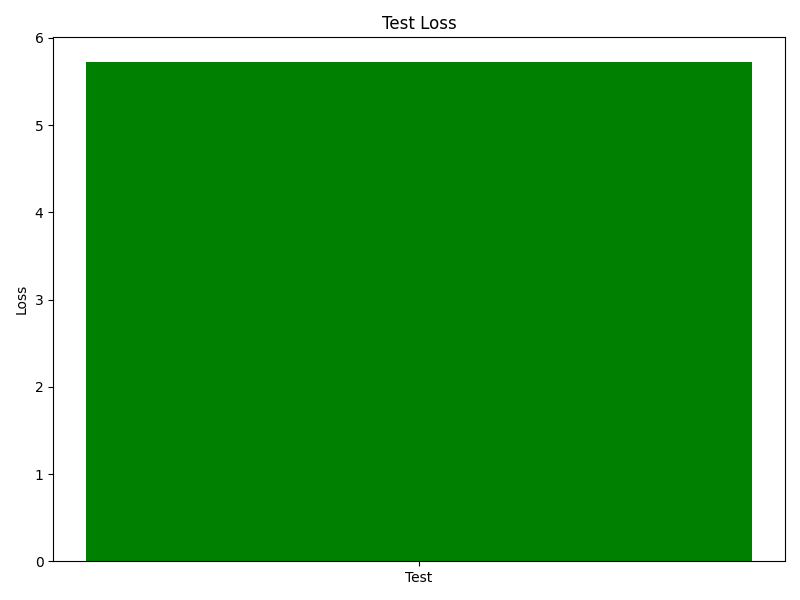

# *Також були в ручну зібрані дані на момент слідкування за роботою коду*
*файл буде додано у LMS

python ./homework_12.py
Train size: 504928
Valid size: 63116
Test size: 63116
{'en': 'Mysterious murders and beatings only serve to further reinforce the impression that Russia is a lawless country.', 'pl': 'Tajemnicze zabójstwa i pobicia tylko potęgują wrażenie rosyjskiego bezprawia.'}
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:04<00:00, 32.86 examples/s] 
Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:54<00:00, 36.91 examples/s] 
Map:                                                                             |████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.44 examples/s]
Train size: 10000
Valid size: 2000
Test size: 2000

{'en': 'Mysterious murders and beatings only serve to further reinforce the impression that Russia is a lawless country.', 'pl': 'Tajemnicze zabójstwa i pobicia tylko potęgują wrażenie rosyjskiego bezprawia.'}
EN tokens: ['<sos>', 'mysterious', 'murders', 'and', 'beatings', 'only', 'serve', 'to', 'further', 'reinforce', 'the', 'impression', 'that', 'russia', 'is', 'a', 'lawless', 'country', '.', '<eos>']
PL tokens: ['<sos>', 'tajemnicze', 'zabójstwa', 'i', 'pobicia', 'tylko', 'potęgują', 'wrażenie', 'rosyjskiego', 'bezprawia', '.', '<eos>']
UNK index: 0
PAD index: 1
Index of 'the' in EN vocab: 13
EN vocab size: 7024
PL vocab size: 12783
Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4729.55 examples/s]
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 5658.84 examples/s]
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 5791.54 examples/s]
{'en': 'Mysterious murders and beatings only serve to further reinforce the impression that Russia is a lawless country.', 'pl': 'Tajemnicze zabójstwa i pobicia tylko potęgują wrażenie rosyjskiego bezprawia.'}
EN tokens: ['<sos>', 'mysterious', 'murders', 'and', 'beatings', 'only', 'serve', 'to', 'further', 'reinforce', 'the', 'impression', 'that', 'russia', 'is', 'a', 'lawless', 'country', '.', '<eos>']
EN ids: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 19, 20, 3]
PL tokens: ['<sos>', 'tajemnicze', 'zabójstwa', 'i', 'pobicia', 'tylko', 'potęgują', 'wrażenie', 'rosyjskiego', 'bezprawia', '.', '<eos>']
PL ids: [2, 0, 4, 5, 0, 6, 0, 7, 8, 9, 10, 3]
Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4284.34 examples/s]
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3744.97 examples/s]
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4176.38 examples/s]
Translation: {'en': 'Mysterious murders and beatings only serve to further reinforce the impression that Russia is a lawless country.', 'pl': 'Tajemnicze zabójstwa i pobicia tylko potęgują wrażenie rosyjskiego bezprawia.'}
EN tokens: ['<sos>', 'mysterious', 'murders', 'and', 'beatings', 'only', 'serve', 'to', 'further', 'reinforce', 'the', 'impression', 'that', 'russia', 'is', 'a', 'lawless', 'country', '.', '<eos>']
EN ids: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 19, 20, 3]
PL tokens: ['<sos>', 'tajemnicze', 'zabójstwa', 'i', 'pobicia', 'tylko', 'potęgują', 'wrażenie', 'rosyjskiego', 'bezprawia', '.', '<eos>']
PL ids: [2, 0, 4, 5, 0, 6, 0, 7, 8, 9, 10, 3]
Dataset({
    features: ['translation', 'en_tokens', 'pl_tokens', 'en_ids', 'pl_ids'],
    num_rows: 10000
})
Приклад: {'en_ids': tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  0, 19,
        20,  3]), 'pl_ids': tensor([ 2,  0,  4,  5,  0,  6,  0,  7,  8,  9, 10,  3]), 'translation': {'en': 'Mysterious murders and beatings only serve to further reinforce the impression that Russia is a lawless country.', 'pl': 'Tajemnicze zabójstwa i pobicia tylko potęgują wrażenie rosyjskiego bezprawia.'}, 'en_tokens': ['<sos>', 'mysterious', 'murders', 'and', 'beatings', 'only', 'serve', 'to', 'further', 'reinforce', 'the', 'impression', 'that', 'russia', 'is', 'a', 'lawless', 'country', '.', '<eos>'], 'pl_tokens': ['<sos>', 'tajemnicze', 'zabójstwa', 'i', 'pobicia', 'tylko', 'potęgują', 'wrażenie', 'rosyjskiego', 'bezprawia', '.', '<eos>']}
EN ids: tensor([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  0, 19,
        20,  3])
PL ids: tensor([ 2,  0,  4,  5,  0,  6,  0,  7,  8,  9, 10,  3])
EN ids shape: torch.Size([64, 32])
PL ids shape: torch.Size([54, 32])
Другий батч EN ids shape: torch.Size([49, 32])
Другий батч PL ids shape: torch.Size([46, 32])ф
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7024, 256, padding_idx=1)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(12783, 256, padding_idx=1)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=12783, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:43<00:00,  3.03it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 12.44it/s] 
Epoch 1/10
        Train Loss: 6.834
        Valid Loss: 6.373
        Best Valid Loss: 6.373
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:38<00:00,  3.17it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.42it/s]
Epoch 2/10
        Train Loss: 6.146
        Valid Loss: 6.170
        Best Valid Loss: 6.170
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:42<00:00,  3.04it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.05it/s]
Epoch 3/10
        Train Loss: 5.699
        Valid Loss: 6.028
        Best Valid Loss: 6.028
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:32<00:00,  3.37it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.95it/s]
Epoch 4/10
        Train Loss: 5.156
        Valid Loss: 5.787
        Best Valid Loss: 5.787
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:47<00:00,  2.92it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.45it/s]
        Train Loss: 4.510
        Valid Loss: 5.732
        Best Valid Loss: 5.732
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:48<00:00,  2.89it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.88it/s]
Epoch 6/10
        Train Loss: 3.808
        Valid Loss: 5.858
        Best Valid Loss: 5.732
Epoch 7/10
        Train Loss: 3.140
        Valid Loss: 5.956
        Best Valid Loss: 5.732
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:11<00:00,  2.38it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.39it/s] 
Epoch 8/10
        Train Loss: 2.720
        Valid Loss: 5.994
        Best Valid Loss: 5.732
Training: |█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.87it/s]
Epoch 9/10
        Train Loss: 2.417
        Valid Loss: 6.139
        Best Valid Loss: 5.732
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:55<00:00,  2.72it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.18it/s] 
Epoch 10/10
        Train Loss: 2.158
        Valid Loss: 6.215
        Best Valid Loss: 5.732
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.18it/s]
| Test Loss: 5.721 | Test PPL: 305.168 |

---
English: The EU and its Member States must transform the verbose declarations reaffirming their commitments into harmonised and collectively effective action.    
Expected Polish: UE i jej państwa członkowskie powinni przekształcić rozwlekłe oświadczenie potwierdzające ich zaangażowanie w zharmonizowane i prawdziwie wspólne działanie.
Predicted translation: <sos> ue i państwa członkowskie muszą być <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> i <unk> i <unk> . <eos>
Source tokens: ['<sos>', 'the', 'eu', 'and', 'its', 'member', 'states', 'must', 'transform', 'the', 'verbose', 'declarations', 'reaffirming', 'their', 'commitments', 'into', 'harmonised', 'and', 'collectively', 'effective', 'action', '.', '<eos>']
Example 1
English: The EU and its Member States must transform the verbose declarations reaffirming their commitments into harmonised and collectively effective action.
Expected Polish: UE i jej państwa członkowskie powinni przekształcić rozwlekłe oświadczenie potwierdzające ich zaangażowanie w zharmonizowane i prawdziwie wspólne działanie.
Predicted Polish: <sos> ue i państwa członkowskie muszą być <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> i <unk> i <unk> . <eos>
------------------------------------------------------------
Example 2
English: Generally speaking, fluctuating exchange rates are not a good thing.
Expected Polish: Przede wszystkim płynne kursy walutowe nie są dobrym pomysłem.
Predicted Polish: <sos> <unk> , <unk> <unk> nie <unk> nie <unk> nie <unk> nie <unk> . <eos>
------------------------------------------------------------
Example 3
English: This is why I believe that we must implement and consider ambitious ideas and not be afraid to come up with and propose such ideas.
Expected Polish: Dlatego uważam, że musimy wdrażać i rozważać ambitne koncepcje, nie bojąc się ich przedstawiać i proponować.
Predicted Polish: <sos> dlatego właśnie uważam , że musimy musimy pokazać i i i i i i nie i i <unk> i <unk> . <eos>
------------------------------------------------------------
Example 4
English: Unresolved conflicts have become the sore point in the Black Sea region.
Expected Polish: Nierozwiązane konflikty stanowią drażliwą kwestię w regionie Morza Czarnego.
Predicted Polish: <sos> stworzono sąd <unk> <unk> <unk> <unk> w regionie regionie . <eos>
------------------------------------------------------------
Example 5
English: The European Investment Bank is very active in this process.
Expected Polish: Europejski Bank Inwestycyjny wykazuje dużą aktywność w tym procesie.
Predicted Polish: <sos> europejski europejski jest jest ważny jest w procesie procesie . <eos>
------------------------------------------------------------
Example 6
English: Every point in the Hungarian Presidency's programme sets these basic values as goals.
Expected Polish: Każdemu punktowi programu węgierskiej prezydencji przyświecają jako cele te właśnie podstawowe wartości.
Predicted Polish: <sos> w w <unk> z <unk> <unk> z <unk> , które <unk> cele . <eos>
------------------------------------------------------------
Example 7
English: To this end, all European Private Companies could have their registered office in one country and their real activities in another.
Expected Polish: W związku z tym wszystkie europejskie spółki prywatne mogą mieć siedzibę statutową w jednym państwie, a faktyczną działalność prowadzić w innym. 
Predicted Polish: <sos> w tym względu na celu <unk> <unk> może być <unk> w <unk> i <unk> i <unk> w . <eos>
------------------------------------------------------------
Example 8
English: However, together with the Council and the Commission, Parliament has laid the foundation for an effective representative organisation that will truly be able to represent Europe and European values and interests around the world.
Expected Polish: Rada, Komisja i Parlament położyły jednak podwaliny pod efektywną organizację reprezentującą UE, która rzeczywiście będzie reprezentować Europę oraz europejskie wartości i interesy w świecie.
Predicted Polish: <sos> jednak jednak parlament i rada i parlament europejski będzie <unk> <unk> <unk> , , , że <unk> <unk> i i europy , a i europy
------------------------------------------------------------
Example 9
English: EU industry is entirely dependent on imports of rare earth elements from China, which has a virtual monopoly in this area, since it controls 97% of global production.
Expected Polish: Przemysł UE jest całkowicie zależny od importu metali ziem rzadkich z Chin, które posiadają w tej dziedzinie wirtualny monopol, gdyż kontrolują 97 % światowej produkcji.
Predicted Polish: <sos> ue jest <unk> <unk> <unk> <unk> z <unk> <unk> , z innymi <unk> , , , w tym , że w tym , że w
------------------------------------------------------------
Example 10
English: Therefore I would like to bring to your attention the mounting evidence of a deteriorating financial situation for farmers.
Expected Polish: Chcę zatem zwrócić waszą uwagę na coraz wyraźniejsze dowody pogorszenia sytuacji finansowej rolników.
Predicted Polish: <sos> dlatego chciałbym zwrócić uwagę na <unk> <unk> <unk> dla rolników dla rolników . <eos>


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:45<00:00,  2.96it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.57it/s] 
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:48<00:00,  2.88it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.63it/s] 
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:51<00:00,  2.82it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.35it/s] 
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:52<00:00,  2.79it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.98it/s] 
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:53<00:00,  2.76it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00, 10.06it/s] 
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:55<00:00,  2.70it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.36it/s]
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:58<00:00,  2.65it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.58it/s]
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:00<00:00,  2.60it/s]
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.43it/s]
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:01<00:00,  2.58it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.30it/s]
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:59<00:00,  2.61it/s] 
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.52it/s] 
Example 1
English: The EU and its Member States must transform the verbose declarations reaffirming their commitments into harmonised and collectively effective action.
Expected Polish: UE i jej państwa członkowskie powinni przekształcić rozwlekłe oświadczenie potwierdzające ich zaangażowanie w zharmonizowane i prawdziwie wspólne działanie.
Predicted Polish: <sos> unia oraz państwa członkowskie musi zapewnić <unk> <unk> <unk> w ich zobowiązania i ich działania . <eos>
Example 2
English: Generally speaking, fluctuating exchange rates are not a good thing.
Expected Polish: Przede wszystkim płynne kursy walutowe nie są dobrym pomysłem.
Predicted Polish: <sos> <unk> , , <unk> <unk> między <unk> są nie są dobrą . <eos>
Example 3
English: This is why I believe that we must implement and consider ambitious ideas and not be afraid to come up with and propose such ideas.
Expected Polish: Dlatego uważam, że musimy wdrażać i rozważać ambitne koncepcje, nie bojąc się ich przedstawiać i proponować.
Predicted Polish: <sos> właśnie uważam uważam , że musimy osiągnąć i znaleźć sposób i i nie <unk> się je <unk> , a nie <unk> te <unk> . <eos>
Example 4
English: Unresolved conflicts have become the sore point in the Black Sea region.
Expected Polish: Nierozwiązane konflikty stanowią drażliwą kwestię w regionie Morza Czarnego.
Predicted Polish: <sos> <unk> centrum zawsze jest <unk> <unk> w w regionie . <eos>
Example 5
English: The European Investment Bank is very active in this process.
Expected Polish: Europejski Bank Inwestycyjny wykazuje dużą aktywność w tym procesie.
Predicted Polish: <sos> europejski inwestycje w europie jest bardzo szczegółowej procesu . <eos>
Example 6
English: Every point in the Hungarian Presidency's programme sets these basic values as goals.
Expected Polish: Każdemu punktowi programu węgierskiej prezydencji przyświecają jako cele te właśnie podstawowe wartości.
Predicted Polish: <sos> zgodnie z <unk> prezydencji <unk> temat te te te cele , jak te cele . <eos>
Example 7
English: To this end, all European Private Companies could have their registered office in one country and their real activities in another.
Expected Polish: W związku z tym wszystkie europejskie spółki prywatne mogą mieć siedzibę statutową w jednym państwie, a faktyczną działalność prowadzić w innym. 
Predicted Polish: <sos> w tym celu zagwarantowania europejskiego europejskiego przedsiębiorstw bez swoimi <unk> , kraju i i i ich do nim w nim . <eos>
Example 8
English: However, together with the Council and the Commission, Parliament has laid the foundation for an effective representative organisation that will truly be able to represent Europe and European values and interests around the world.
Expected Polish: Rada, Komisja i Parlament położyły jednak podwaliny pod efektywną organizację reprezentującą UE, która rzeczywiście będzie reprezentować Europę oraz europejskie wartości i interesy w świecie.
Predicted Polish: <sos> jednak z zadowoleniem przyjmuje rada i komisja parlament będzie <unk> dla dla dla dla rządu będzie będzie mieć europę i i i i na dobrobyt 
Example 9
English: EU industry is entirely dependent on imports of rare earth elements from China, which has a virtual monopoly in this area, since it controls 97% of global production.
Expected Polish: Przemysł UE jest całkowicie zależny od importu metali ziem rzadkich z Chin, które posiadają w tej dziedzinie wirtualny monopol, gdyż kontrolują 97 % światowej produkcji.
Predicted Polish: <sos> przemysł ue jest jest od od od <unk> z z z <unk> , , która jest <unk> <unk> w tym , a to zaledwie 40
Example 10
English: Therefore I would like to bring to your attention the mounting evidence of a deteriorating financial situation for farmers.
Expected Polish: Chcę zatem zwrócić waszą uwagę na coraz wyraźniejsze dowody pogorszenia sytuacji finansowej rolników.
Predicted Polish: <sos> dlatego chciałabym zwrócić państwa uwagę na <unk> wypłaty wyjścia dla sytuacji transferu sytuacji . <eos>
----
Example 6300
English: Is it not time to rationalise and bring some sense to this situation and cut adrift some of the contrived political correctness that is driving it?
Expected Polish: Czy nie nadeszła pora na racjonalizację i zdroworozsądkowe podejście do sytuacji, czy nie pora ograniczyć trochę tę naciąganą poprawność polityczną, która napędza tę sytuację?
Predicted Polish: <sos> czy nie jest teraz <unk> i i inni , żeby w tej sytuacji i <unk> się z <unk> na <unk> , jaki jest to ?

Example 10532
English: If we are to expect results from our children we must provide our teachers with exemplary training.
Expected Polish: Jeżeli mamy oczekiwać rezultatów od naszych dzieci, musimy zapewnić naszym nauczycielom przykładne szkolenie.
Predicted Polish: <sos> jeśli my , że musimy się z naszych naszych , musimy zadbać naszą dostawy z <unk> . <eos>

-----
Example 14010
English: A prosperous European industry is obviously crucial for achieving the Lisbon goals.
Expected Polish: Dobrze prosperujący europejski przemysł stanowi ewidentnie klucz do osiągnięcia celów lizbońskich.
Predicted Polish: <sos> <unk> on forma europejskiej jest jest dla realizacji realizacji celów . <eos>

-----

Example 22563
English: It is also intended to increase competitiveness and improve the quality of life of the EU's citizens.
Expected Polish: Ma ona za zadanie zwiększenie konkurencyjności i poprawienie jakości życia obywateli UE.
Predicted Polish: <sos> 40 również również zwiększyć konkurencyjność i poprawy jakości obywateli obywateli ue . <eos>

----------

Example 63115
English: These issues need to be reassessed in the light of the experience we have gained in recent years.
Expected Polish: Trzeba dokonać ponownej oceny tych zagadnień w świetle doświadczeń wyniesionych w ostatnich latach.
Predicted Polish: <sos> omawiane kwestie muszą być <unk> <unk> w <unk> z którymi się w latach . <eos>
Example 63116
English: The issue of the financial instrument has become part of the interinstitutional struggle which has been going on for a year now.
Expected Polish: Kwestia instrumentu finansowego stała się przedmiotem międzyinstytucjonalnych zmagań, które trwają już od niemal roku.
Predicted Polish: <sos> kwestia element finansowej finansowej był <unk> część z o o 2006 r . <eos>
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
METEOR: 0.2126
preds_len: 63116 refs_len: 63116
preds_sample: ['unia oraz państwa członkowskie musi zapewnić <unk> <unk> <unk> w ich zobowiązania i ich działania .', '<unk> , , <unk> <unk> między <unk> są nie są dobrą .', 'właśnie uważam uważam , że musimy osiągnąć i znaleźć sposób i i nie <unk> się je <unk> , a nie <unk> te <unk> .']
refs_sample: [['UE i jej państwa członkowskie powinni przekształcić rozwlekłe oświadczenie potwierdzające ich zaangażowanie w zharmonizowane i prawdziwie wspólne działanie.'], ['Przede wszystkim płynne kursy walutowe nie są dobrym pomysłem.'], ['Dlatego uważam, że musimy wdrażać i rozważać ambitne koncepcje, nie bojąc się ich przedstawiać i proponować.']]
preds_len: 63116 refs_len: 63116
preds_sample: ['unia oraz państwa członkowskie musi zapewnić <unk> <unk> <unk> w ich zobowiązania i ich działania .', '<unk> , , <unk> <unk> między <unk> są nie są dobrą .', 'właśnie uważam uważam , że musimy osiągnąć i znaleźć sposób i i nie <unk> się je <unk> , a nie <unk> te <unk> .']
refs_sample: [['UE i jej państwa członkowskie powinni przekształcić rozwlekłe oświadczenie potwierdzające ich zaangażowanie w zharmonizowane i prawdziwie wspólne działanie.'], ['Przede wszystkim płynne kursy walutowe nie są dobrym pomysłem.'], ['Dlatego uważam, że musimy wdrażać i rozważać ambitne koncepcje, nie bojąc się ich przedstawiać i proponować.']]
Done. Результати збережені у results.txt

# В нашому виадку METEOR = 0.2126 підтверджує те, що ми бачили у прикладах: модель навчається, але переклади ще слабкі.